In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

!pip install japanize-matplotlib
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

     |████████████████████████████████| 4.1MB 1.7MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120193 sha256=40b472c98b22a5e72370a52972b61c7da2487cbe328d75def852c94d7b729ff9
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み
今回使用しているデータは2019年1月～2020年10月までの任天堂の株価データになります。<br>
データ元→https://kabuoji3.com/stock/7974/


In [30]:
df_2019 = pd.read_csv("drive/My Drive/統計/7974_2019.csv" ,header=1, encoding="shift-jis")
df_2019 = df_2019.drop("終値調整値" , axis=1)
df_2019.head()

,日付,始値,高値,安値,終値,出来高
0,2019-01-04,28410,28630,27420,28030,2581000
1,2019-01-07,29330,29755,29115,29670,1934300
2,2019-01-08,29715,30200,29600,30020,1662700
3,2019-01-09,30440,30980,29865,30730,1911200
4,2019-01-10,30350,30760,29735,29795,2021000


In [31]:
df_2020 = pd.read_csv("drive/My Drive/統計/7974_2020.csv" ,header=1, encoding="shift-jis")
df_2020 = df_2020.drop("終値調整値" , axis=1)
df_2020.head()

,日付,始値,高値,安値,終値,出来高
0,2020-01-06,43010,43090,42510,42740,1154600
1,2020-01-07,43040,43500,42890,42940,1167600
2,2020-01-08,42500,42840,41610,42640,1484400
3,2020-01-09,43550,43600,43160,43380,1030800
4,2020-01-10,43220,43780,43140,43440,826300


In [63]:
df = pd.concat([df_2019, df_2020],ignore_index = True)
df.head()

,日付,始値,高値,安値,終値,出来高
0,2019-01-04,28410,28630,27420,28030,2581000
1,2019-01-07,29330,29755,29115,29670,1934300
2,2019-01-08,29715,30200,29600,30020,1662700
3,2019-01-09,30440,30980,29865,30730,1911200
4,2019-01-10,30350,30760,29735,29795,2021000


In [64]:
df.describe()

,始値,高値,安値,終値,出来高
count,427.000000,427.000000,427.000000,427.000000,4.270000e+02
mean,41658.255269,42095.550351,41230.854801,41689.402810,1.469025e+06
std,7217.330209,7222.310641,7164.797225,7191.492663,7.680473e+05
min,28410.000000,28630.000000,27420.000000,28030.000000,4.753000e+05
25%,37875.000000,38290.000000,37445.000000,37895.000000,9.702000e+05
50%,40800.000000,41100.000000,40410.000000,40900.000000,1.301200e+06
75%,44980.000000,45250.000000,44435.000000,44905.000000,1.766000e+06
max,60500.000000,61300.000000,60000.000000,60920.000000,8.919200e+06


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      427 non-null    object
 1   始値      427 non-null    int64 
 2   高値      427 non-null    int64 
 3   安値      427 non-null    int64 
 4   終値      427 non-null    int64 
 5   出来高     427 non-null    int64 
 6   終値調整値   427 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 23.5+ KB


### 仮説
今回「株価が前日に下落した場合、当日の株価は上がりやすい」という仮説を立て検証していきたいと思います。<br>[
なぜこのような仮説を立てたのかというと、株は安いときに買い、高いときに売るというのが儲かる法則の一つであります。この法則にもとづき前日に株価が下がったときは、当日買いが増え株価が上がり、逆に前日に株価が上がったときは当日売りが増え株価が下がると考えたため、このような仮説を立てました。


### 帰無仮説
今回帰無仮説を、「前日の株価の上昇もしくは下落は当日の株価の増減率に影響を与えない」とします。<br>
もっと砕けた言葉でいうと「前日の株価が上昇したグループと前日の株価が下落したグループの当日の株価増減率の平均は同じである」というのが帰無仮説になります。<br>


### データの生成

In [28]:
#当日株価が上昇したか下落したかのフラグを作成
#上昇→１、下落→０

df["Rise or fall"] = [ 1 if df["終値"][i] - df["始値"][i] >= 0 else 0  for i in range(len(df))]
df["Rise or fall"]

0      0
1      1
2      1
3      1
4      0
      ..
422    0
423    0
424    1
425    1
426    0
Name: Rise or fall, Length: 427, dtype: int64

In [32]:
#当日の株価上昇率の算出
#(当日の終値 - 当日の始値）÷　当日の始値

df["rate"] = (df['終値'] - df['始値']) / df['始値']

In [49]:
#前日に上昇したか下落したかのフラグ
df["before rise or fall"] = df['Rise or fall'].shift(1)

In [51]:
#Nanがある最初の行を削除
df= df.dropna(axis = 0)

In [ ]:
df.head()

In [53]:
#前日株価が上昇したグループと、前日株価が下落したグループで分ける
df_rise = df[df["before rise or fall"] == 1]
df_fall = df[df["before rise or fall"] == 0]

In [54]:
#前日株価が上昇したもの
df_rise.describe()

,始値,高値,安値,終値,出来高,終値調整値,Rise or fall,rate,before rise or fall
count,223.000000,223.000000,223.000000,223.000000,2.230000e+02,223.000000,223.000000,223.000000,223.0
mean,41701.188341,42132.556054,41282.982063,41728.587444,1.437546e+06,41728.587444,0.497758,0.000741,1.0
std,7402.815589,7425.842838,7367.729396,7413.276676,6.174055e+05,7413.276676,0.501120,0.013727,0.0
min,29000.000000,29595.000000,28580.000000,29235.000000,5.619000e+05,29235.000000,0.000000,-0.033496,1.0
25%,37740.000000,38195.000000,37320.000000,37800.000000,9.922000e+05,37800.000000,0.000000,-0.007449,1.0
50%,40740.000000,40990.000000,40400.000000,40570.000000,1.296700e+06,40570.000000,0.000000,-0.000426,1.0
75%,45025.000000,45245.000000,44435.000000,45035.000000,1.791600e+06,45035.000000,1.000000,0.008690,1.0
max,60500.000000,61300.000000,60000.000000,60920.000000,4.716900e+06,60920.000000,1.000000,0.048437,1.0


In [55]:
#前日株価が下落したもの
df_fall.describe()

,始値,高値,安値,終値,出来高,終値調整値,Rise or fall,rate,before rise or fall
count,203.000000,203.000000,203.000000,203.000000,2.030000e+02,203.000000,203.000000,203.000000,203.0
mean,41676.354680,42121.231527,41241.625616,41713.645320,1.498128e+06,41713.645320,0.551724,0.001300,0.0
std,6982.407845,6964.328005,6903.194810,6909.693812,9.039038e+05,6909.693812,0.498547,0.015099,0.0
min,28845.000000,29680.000000,28575.000000,29250.000000,4.753000e+05,29250.000000,0.000000,-0.048916,0.0
25%,38165.000000,38535.000000,37885.000000,38150.000000,9.361500e+05,38150.000000,0.000000,-0.008211,0.0
50%,40900.000000,41260.000000,40590.000000,40970.000000,1.301200e+06,40970.000000,1.000000,0.000525,0.0
75%,44915.000000,45255.000000,44470.000000,44750.000000,1.743900e+06,44750.000000,1.000000,0.009294,0.0
max,60480.000000,60700.000000,58980.000000,59700.000000,8.919200e+06,59700.000000,1.000000,0.073231,0.0


### ヒストグラムによる可視化


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


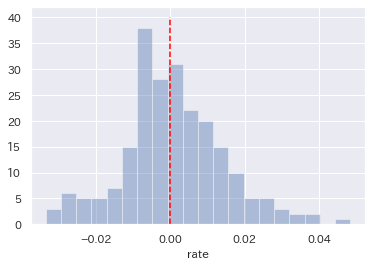

In [59]:
#前日株価が上昇した、当日の株価rateの分布
sns.distplot(df_rise["rate"], kde=False, rug=False, bins=20) 
plt.vlines([0], 0 , 40, "red", linestyles='dashed')
plt.show()  

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


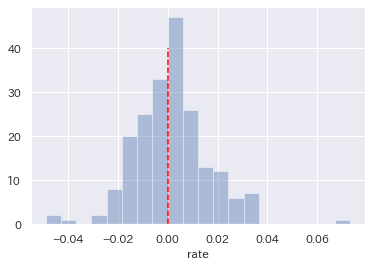

In [60]:
#前日株価が下落した、当日の株価rateの分布
sns.distplot(df_fall["rate"], kde=False, rug=False, bins=20) 
plt.vlines([0], 0 , 40, "red", linestyles='dashed')
plt.show()  

上の図が、前日に株価が上昇したときの当日の株価の増減率の分布グラフ<br>
下の図が、前日に株価が下落したときの当日の株価の増減率の分布グラフ<br>
今、このヒストグラムを見てみると上の図のほうがrateの低いほうに分布の中心があるようにも思えます。仮にそうであるとするならば、前日の株価の上昇・下落によって当日の株価の値動きも変化が起こるということになります。

### 箱ひげ図による可視化

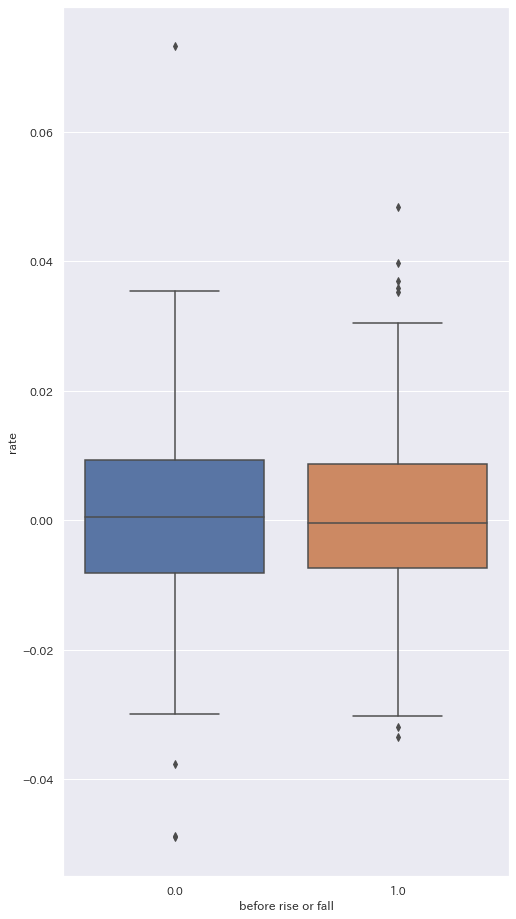

In [62]:
plt.figure(figsize=(8,16))
sns.boxplot(x='before rise or fall', y='rate', data=df)
plt.show()

今、箱ひげ図でのそれぞれの分布を見てみたが若干前日株価が下がったグループのほうがrateの中央値が上であることが分かります。

### 統計解析
母平均の差を検定する。<br>
まず母分散が分からない場合、母平均が等しいかどうかを検定するには2つのパターンに分けられます。<br>
・ケース１：２つの母分散はわからないが、等しいとみなせる場合<br>
・ケース２：２つの母分散の値が分からず、等しいとも限らない場合<br>
<br>
まず、母分散が等しいかどうかを検定します。

### 母分散が等しいかどうかを調べる。
①帰無仮説:「前日の株価が上昇したグループと前日の株価増減率$σ_r^2$と下落したグループの当日の株価増減率の分散$σ_f^2$は等しい。」とする。$H_0(σ_r^2=σ_f^2)$


In [67]:
#それぞれの不偏分散を求める
rise_var = np.var(df_rise["rate"].values, ddof=1)# riseの不偏分散
fall_var = np.var(df_fall["rate"].values, ddof=1)# fallの不偏分散
print("前日の株価が上昇したグループの不偏分散：{}".format(rise_var))
print("前日の株価が下落したグループの不偏分散：{}".format(fall_var))

前日の株価が上昇したグループの不偏分散：0.00018842892836152598
前日の株価が下落したグループの不偏分散：0.00022798040469871952


In [69]:
#統計量Fの算出
F = rise_var / fall_var
print("統計量F:{}".format(F))

統計量F:0.8265137023970917


In [93]:
rise_m = len(df_rise) - 1  # rise_rateの自由度
fall_n = len(df_fall) - 1  # fall_rateの自由度

rv = stats.f(rise_m,fall_n)
rv.interval(0.9)#90%の信頼区間

(0.798, 1.255)

今回、検定統計量Fは棄却域に含まれません。そのため帰無仮説である「前日の株価が上昇したグループと前日の株価増減率$σ_r^2$と下落したグループの当日の株価増減率の分散$σ_f^2$は等しい。」は棄却されません。ということは、2つの母分散は等しくないとは言えないことが分かる。<br>


以上の結果から、母分散が等しいと仮定して母平均が等しいかどうかを検定していきます。<br>
ここでは2つの母平均が等しいものと仮定します。<br>
従って、帰無仮説は「前日の株価が上昇したグループの当日の株価増減率の平均$μ_r$と前日の株価が下落したグループの当日の株価増減率の平均$μ_f$は同じである」として考えていきます。($μ_r=μ_f$)

In [109]:
U_rf = (rise_var * rise_m + fall_var * fall_n) / (rise_m + fall_n)

In [110]:
rise_mean = df_rise["rate"].mean() 
fall_mean = df_fall["rate"].mean() 

T = (rise_mean - fall_mean)/np.sqrt((1/(rise_m + 1) + 1/(fall_n + 1))*U_rf)
T

-0.400

0.001

この検定統計量Tは自由度（424）のt分布に従う

In [114]:
rv = stats.t(424)
rv.interval(0.9)#90%の信頼区間

(-1.648, 1.648)

# 棄却されない